<a href="https://colab.research.google.com/github/Mellandd/umucv/blob/master/notebooks/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook vamos a mostrar como hacer uso de los transformers en visión artificial. Un transformer, básicamente, es un nuevo tipo de red neuronal que se basa en el concepto de la **atención**. Estas redes son el estado del arte en las áreas de la visión artificial y del procesamiento del lenguaje natural.

Resumidamente, el mecanismo de atención trata de seleccionar que partes del texto o imagen son más relevantes usando un mecanismo que trata de imitar la atención humana (mediante nuestra visión).

La red que vamos a usar es Vision Transformer (ViT), de Google, que es básicamente una adaptación de BERT a la visión artificial.

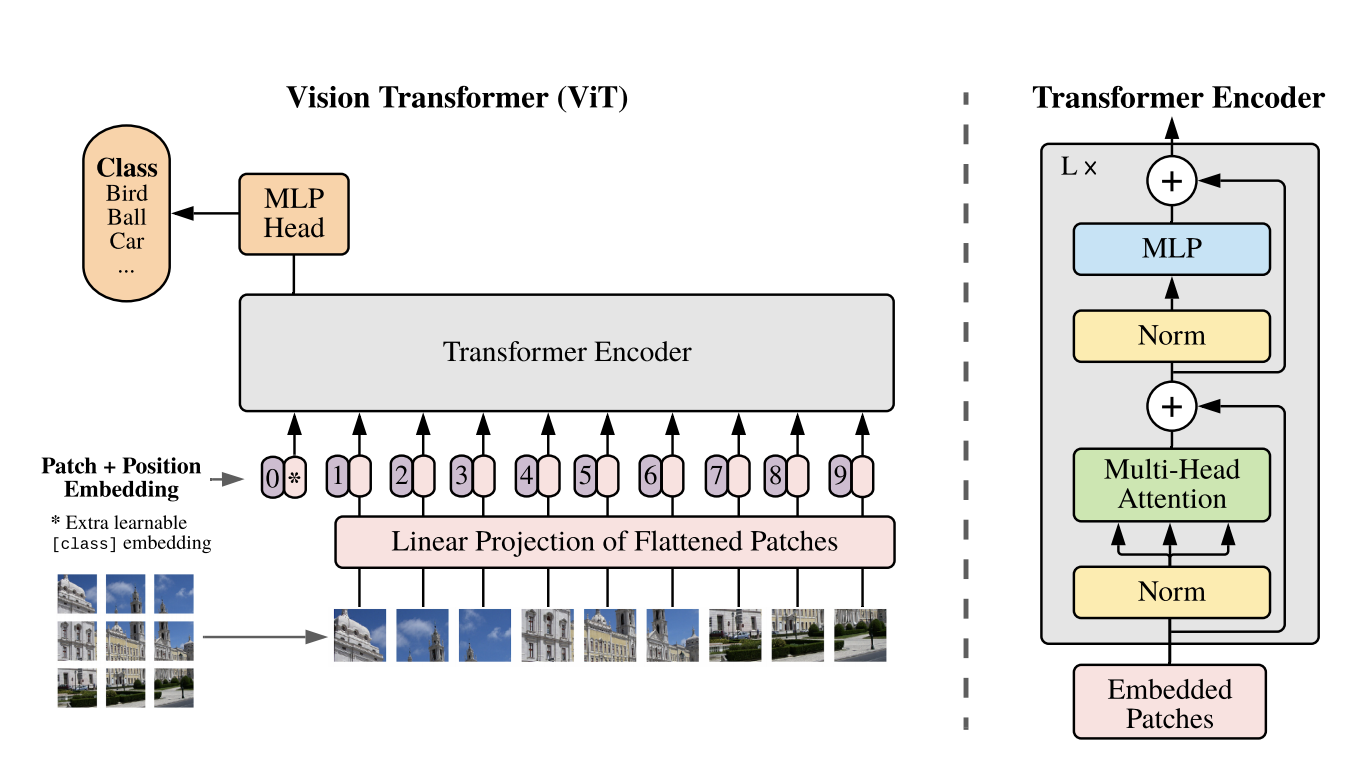

Para más información sobre los Transformers, podemos visitar el artículo original: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) (Lo recomiendo bastante, es uno de los artículos más influyentes de los últimos años y es corto).

Como podemos ver, ViT solamente usa el encoder de un Transformer, y le añade un head de clasificación. Podemos ver de forma resumida cómo funcionaría un Transformer completo en el siguiente diagrama:

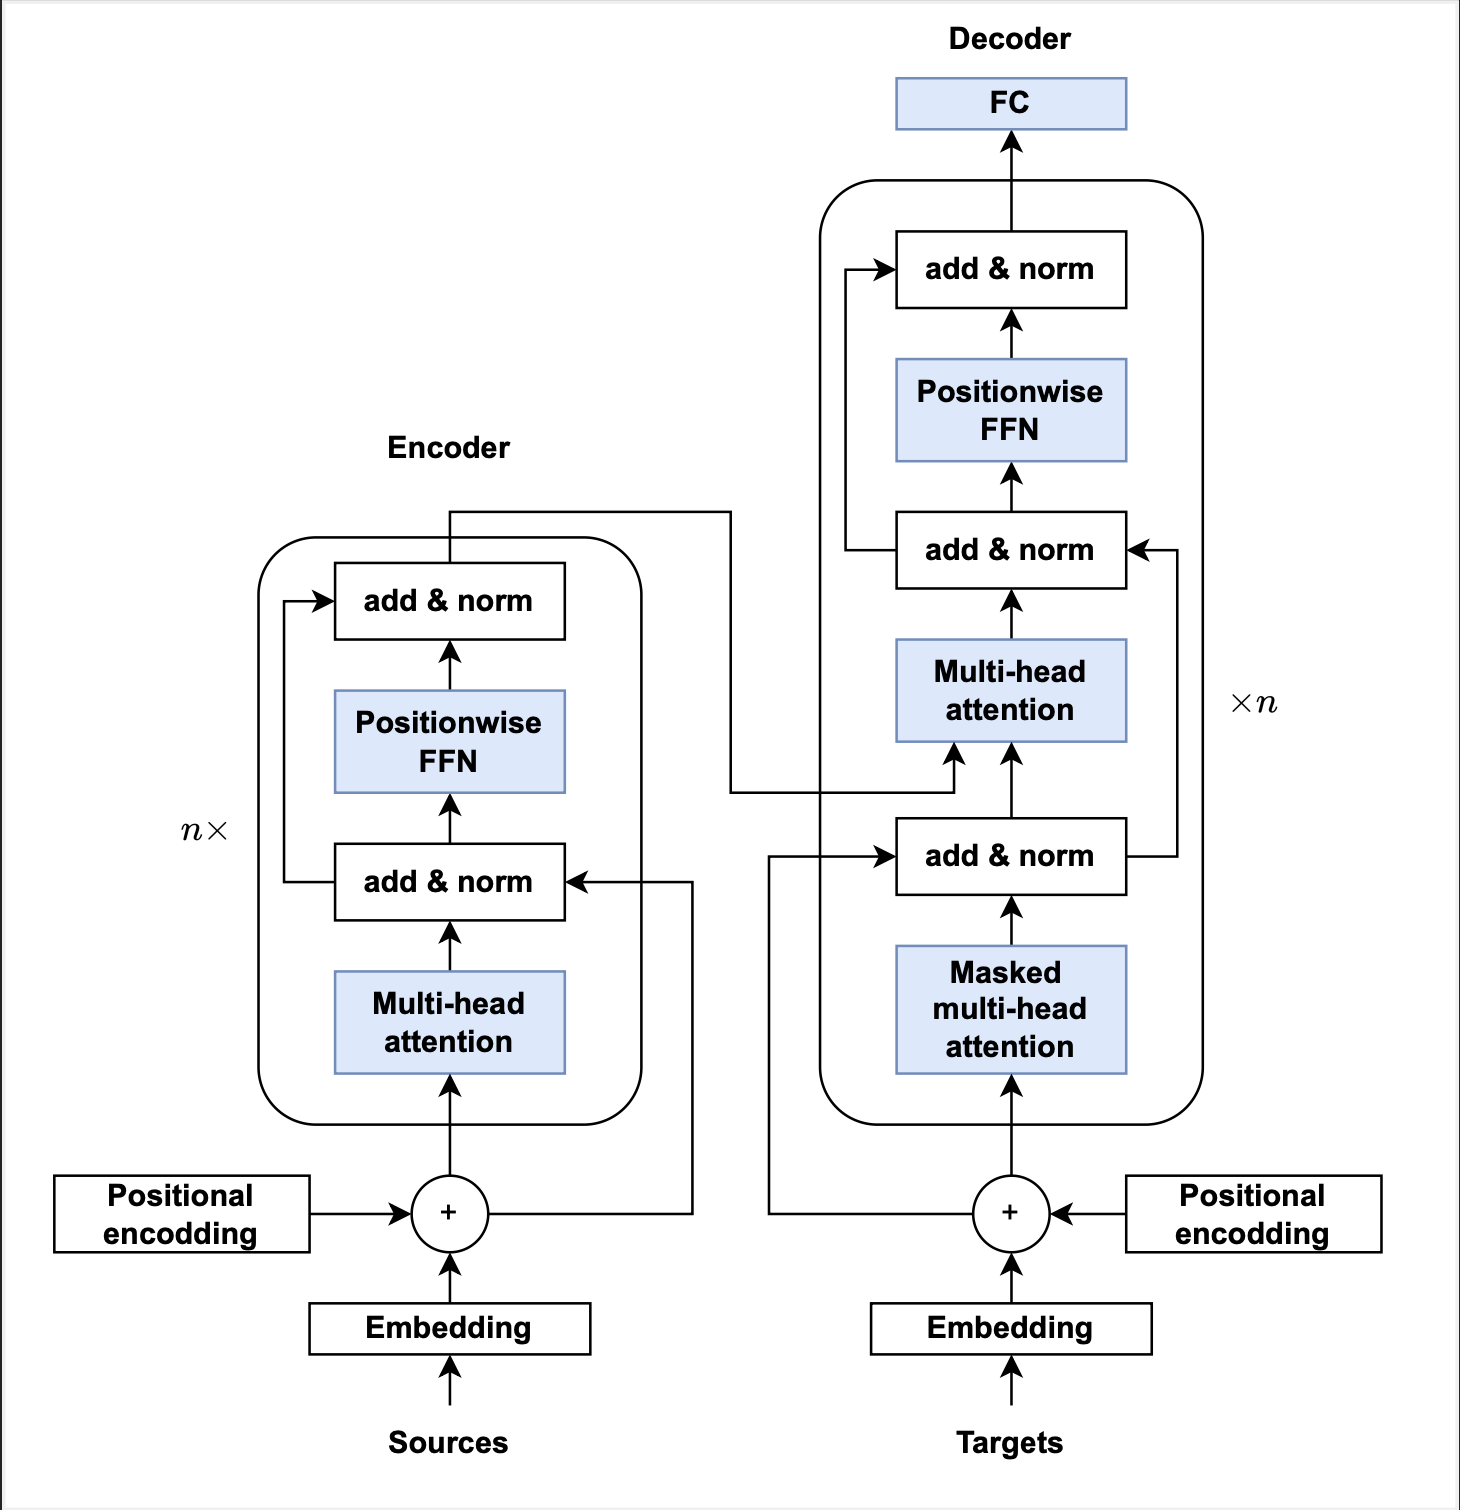



Este diagrama es propio (es para mi TFG :) )

Como vemos, esta red sigue la estructura encoder-decoder, típica de las redes SotA en estos campos (son muy importantes para traducción, por ejemplo). Para aprender más a fondo sobre este campo también recomiendo el libro de [Dive into Deep Learning](https://d2l.ai/chapter_attention-mechanisms/index.html).

También podemos ver los detalles concretos del modelo que vamos a usar en la propia página de [Hugging Face](https://huggingface.co/google/vit-base-patch16-224-in21k).

Primero vamos a instalar todo lo que necesitamos.

In [ ]:
!pip install -q transformers datasets torchvision

     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 325 kB 71.5 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
     |████████████████████████████████| 880 kB 55.6 MB/s 
     |████████████████████████████████| 212 kB 71.1 MB/s 
     |████████████████████████████████| 1.1 MB 53.3 MB/s 
     |████████████████████████████████| 136 kB 79.3 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 70.4 MB/s 
     |████████████████████████████████| 271 kB 79.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

Vamos a tratar de hacer fine-tuning de una versión pre-entrenada del modelo. Vamos a usar las librerías de transformers y de datasets, y vamos a entrenar con el dataset de "cats vs dogs", que es un dataset de clasificación con dos clases: gatos y perros. (podríamos usar cualquiera de los datasets alojados en Hugging Face).

Estamos usando Pytorch (que no Tensorflow), y es importante la primera línea para indicar que queremos usar la gpu para entrenar.

Como se puede observar, cargar un dataset de Hugging Face es extremadamente fácil, ya que solamente hay que incluir el nombre.

In [ ]:
from datasets import load_dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_ds = load_dataset("cats_vs_dogs")
train_ds = train_ds['train']
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
test_ds = splits['test']

train_ds
train_ds.features

Using custom data configuration default


Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/.cache/huggingface/datasets/cats_vs_dogs/default/0.0.1/cf5b67b98947a9581c08ea2cc3ba991540f5df2b8fb727f703c48fc0200ba52c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

{'image': Image(decode=True, id=None),
 'image_file_path': Value(dtype='string', id=None),
 'labels': ClassLabel(num_classes=2, names=['cat', 'dog'], id=None)}

Como vemos, el dataset contiene una serie de imágenes, donde cada imagen tiene asociada una etiqueta con perro o gato. Mostramos la primera imagen del dataset por ejemplo:

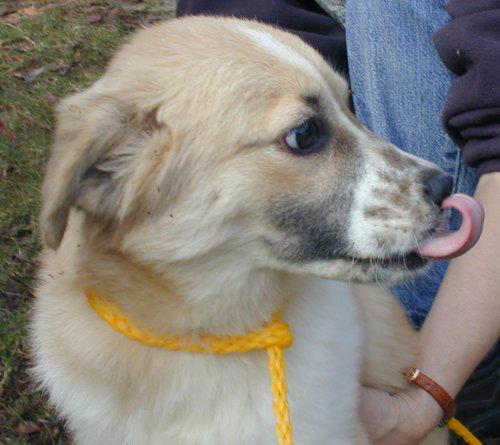

In [ ]:
train_ds[0]['image']

Ahora, necesitamos unos diccionaros para las etiquetas, ya que se necesitan para el entrenamiento y la evaluación. 

In [ ]:
id2label = {id:labels for id,labels in enumerate(train_ds.features['labels'].names)}
label2id = {labels:id for id,labels in id2label.items()}
id2label

{0: 'cat', 1: 'dog'}

# Preprocesamiento
Lo primero que hay que hacer es preprocesar las imágenes del dataset a un formato que entienda el modelo. La librería de transformers tiene, para cada modelo preentrenado, un extractor de características asociado que podemos usar para transformar las imágenes.

En nuestro caso, lo que vamos a necesitar es redimensionar las imágenes al valor que espera el modelo. Con eso, el extractor va a devolver unos valores llamados pixel_values que es lo que necesita el modelo.

In [ ]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Con la función transform vamos a transformar las imágenes al formato deseado. Primero hay que pasarlas a RGB ya que queremos quitar la capa de transparencia del png. Lo vamos a devolver como un tensor de pytorch.

Después, con el método with_transform vamos a transformar los datasets. Este método es un método *on the fly*, es decir, es *lazy* y no se va a ejecutar la transformación hasta que no se acceda a cada una de las filas del dataset.

Vamos a necesitar los labels originales también, así que los agregamos a los objetos generados por el feature_extractor.

In [ ]:
def transform(example_batch):
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_train_ds = train_ds.with_transform(transform)
prepared_test_ds = test_ds.with_transform(transform)

# Entrenamiento

A continuación vamos a cargar el modelo, al que le tenemos que pasar el diccionario de las etiquetas y el número de ellas que hay. Es importante la último línea para mandar el modelo a la GPU, ya que si no el entrenamiento es **mucho** mas lento (a mí me llega a tardar 8 minutos con GPU y 12 horas con la CPU en el colab).

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels = 2,
                                                  id2label = id2label,
                                                  label2id = label2id)
model = model.to(device)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


A continuación, tenemos que determinar los argumentos del Trainer, que es con lo que vamos a entrenar el modelo. Todos los argumentos puestos son bastante estándar. Vamos a hacer sólo un epoch ya que es más que suficiente para este dataset (como veremos, con los primeros ejemplos ya tiene una precisión de más del 99%).

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"test-cats-vs-dogs",
    save_strategy = "steps",
    evaluation_strategy = "steps",
    save_steps = 500,
    eval_steps = 500,
    learning_rate = 2e-5,
    per_device_train_batch_size = 10,
    per_device_eval_batch_size = 10,
    num_train_epochs = 1,
    weight_decay = 0.01,
    fp16 = True,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    logging_dir = 'logs',
    remove_unused_columns = False,
)

A continuación, vamos a definir la métrica que vamos a usar. En nuestro caso, al ser un problema de clasificación, nos interesa la métrica de precisión, aunque podríamos usar otras como F1.

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return metric.compute(predictions = predictions, references = labels)

Después de esto, vamos a necesitar definir un data collator.

Esta función es la encargada de crear los batches del entrenamiento a partir de una lista de elementos del dataset.

Con esto, ya podemos definir el Trainer. Esta función sirve para entrenar los modelos que se encuentran alojados en Hugging Face y que encapsula el proceso de entrenamiento de tanto Pytorch como Tensorflow.

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])}

trainer = Trainer(
    model,
    args,
    train_dataset = prepared_train_ds,
    eval_dataset = prepared_test_ds,
    compute_metrics = compute_metrics,
    data_collator = collate_fn,
    tokenizer = feature_extractor,
  )

Using amp half precision backend


Con todo esto, vamos a entrenarlo, que es tan fácil como ejecutar la siguiente función.

Vamos a realizar una validación cada 500 steps de entrenamiento, en nuestro caso por simplicidad vamos a realizarla sobre el conjunto de test ya que no hemos indicado ningún otro conjunto.

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 21069
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2107


Step,Training Loss,Validation Loss,Accuracy
500,0.092100,0.027069,0.993877
1000,0.030500,0.013848,0.997247
1500,0.020700,0.010950,0.997912
2000,0.020600,0.006595,0.999003


***** Running Evaluation *****
  Num examples = 21069
  Batch size = 10
Saving model checkpoint to test-cats-vs-dogs/checkpoint-500
Configuration saved in test-cats-vs-dogs/checkpoint-500/config.json
Model weights saved in test-cats-vs-dogs/checkpoint-500/pytorch_model.bin
Feature extractor saved in test-cats-vs-dogs/checkpoint-500/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 21069
  Batch size = 10
Saving model checkpoint to test-cats-vs-dogs/checkpoint-1000
Configuration saved in test-cats-vs-dogs/checkpoint-1000/config.json
Model weights saved in test-cats-vs-dogs/checkpoint-1000/pytorch_model.bin
Feature extractor saved in test-cats-vs-dogs/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 21069
  Batch size = 10
Saving model checkpoint to test-cats-vs-dogs/checkpoint-1500
Configuration saved in test-cats-vs-dogs/checkpoint-1500/config.json
Model weights saved in test-cats-vs-dogs/checkpoint-1500/pytorch_model.bin
F

TrainOutput(global_step=2107, training_loss=0.039476746227371226, metrics={'train_runtime': 1424.3906, 'train_samples_per_second': 14.792, 'train_steps_per_second': 1.479, 'total_flos': 1.6326787291898388e+18, 'train_loss': 0.039476746227371226, 'epoch': 1.0})

Como se puede ver, con sólo los primeros ejemplos ya es capaz de acertar el 99% de los elementos del dataset completo, por lo que es prácticamente perfecto.

# Evaluación

Después de esto, vamos a probar con el conjunto de test. Vamos a predecir con el modelo y a ver qué métricas obtenemos

In [ ]:
outputs = trainer.predict(prepared_test_ds)
print(outputs.metrics)

***** Running Prediction *****
  Num examples = 2341
  Batch size = 10


{'test_loss': 0.01667606458067894, 'test_accuracy': 0.9957283212302435, 'test_runtime': 24.6676, 'test_samples_per_second': 94.902, 'test_steps_per_second': 9.527}


Vemos que obtenemos una precisión del 99.57% en el conjunto de test, unos resultados muy espectaculares.

Por último, ya que estamos en un problema de clasificación, también podríamos ver la matriz de confusión que obtenemos. Es muy fácil de obtener a partir de la librería de scikit learn.

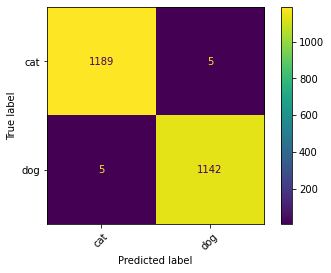

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['labels'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

Como vemos, sólo falla en 10 de los ejemplos del conjunto de test.

Gracias a la librería de transformers, estos modelos pre-entrenados son muy fáciles de usar, y funcionan extremadamente bien en tareas concretas haciendo fine-tuning (gracias al transfer-learning).